# Preprocessing Data Notebook

## Import Libraries

In [1]:
import cv2
import os
import numpy as np
import imutils
from tqdm import tqdm
from PIL import Image, ImageOps
import random
import matplotlib.pyplot as plt

## Display Video Times

In [2]:
original_video_files = os.listdir("./Dataset/Original_Data/")

In [9]:
def get_video_times(video_path):
    
    """
    Get Duration of each Video
    
    :param video_path: str, path to the video file
    """
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the frame rate and total number of frames
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the duration in seconds
    duration = total_frames / fps

    # Print the duration
    print(f"Video duration: {duration:.2f} seconds for the Video {video_path}")

    # Release the video capture object and close any windows
    cap.release()
    cv2.destroyAllWindows()

In [10]:
for video in original_video_files:
    get_video_times("./Dataset/Original_Data/"+video)

Video duration: 18.17 seconds for the Video ./Dataset/Original_Data/Abhay_Bhujangasana.mp4
Video duration: 28.90 seconds for the Video ./Dataset/Original_Data/Abhay_Padmasana.mp4
Video duration: 43.57 seconds for the Video ./Dataset/Original_Data/Abhay_Shavasana.mp4
Video duration: 50.70 seconds for the Video ./Dataset/Original_Data/Abhay_Tadasana.mp4
Video duration: 44.40 seconds for the Video ./Dataset/Original_Data/Abhay_Trikonasana.mp4
Video duration: 59.20 seconds for the Video ./Dataset/Original_Data/Abhay_Vrikshasana.mp4
Video duration: 47.10 seconds for the Video ./Dataset/Original_Data/Ameya_Bhujangasana.mp4
Video duration: 44.60 seconds for the Video ./Dataset/Original_Data/Ameya_Padmasana.mp4
Video duration: 53.07 seconds for the Video ./Dataset/Original_Data/Ameya_Shavasana.mp4
Video duration: 52.10 seconds for the Video ./Dataset/Original_Data/Ameya_Tadasana.mp4
Video duration: 50.47 seconds for the Video ./Dataset/Original_Data/Ameya_Trikonasana.mp4
Video duration: 51.90 

## Extract Images from the Videos

In [13]:
def extract_frames(video_path, interval, output_dir, n=0, output_name='image'):
    """
    Extract frames from a video file at a given interval and save them as images in the specified output directory.
    
    :param video_path: str, path to the video file
    :param interval: float, time interval between frames to be extracted (in seconds)
    :param output_dir: str, path to the output directory where the extracted frames will be saved
    :param n: int, number of seconds to ignore at the start and end of the video
    :param output_name: str, name to be used for the output images
    """
    # Read the video file
    vidcap = cv2.VideoCapture(video_path)

    # Get the total number of frames and FPS of the video
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    # Calculate the start and end frame numbers to be extracted
    start_frame = int(n * fps)
    end_frame = total_frames - int(n * fps)

    # Initialize variables
    success = True
    count = 0

    while success:
        # Set the frame at the given interval
        frame_number = int(start_frame + count*interval*fps)
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

        # Read the frame
        success, image = vidcap.read()

        # Check if a frame was successfully obtained
        if success and frame_number < end_frame:
            # Construct the filename
            filename = os.path.join(output_dir, f'{output_name}_{frame_number/fps:.1f}s.jpg')

            # Save the image with the filename
            cv2.imwrite(filename, image)

            # Increment the count
            count += 1

    # Release the video capture object
    vidcap.release()


In [14]:
for video in tqdm(original_video_files):
    filename = video.split(".")[0]
    
    output_dir = f"./Dataset/Extracted_Images/{filename}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    video_path = f"./Dataset/Original_Data/{video}"
    interval = 0.1
    n = 5
    output_name = filename
    
    extract_frames(video_path, interval, output_dir, n=0, output_name='image')

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [56:33<00:00, 38.56s/it]


## Clean and Rename

In [20]:
# Remove Images of first 5 seconds as it mostly has people starting  a position
def remove_images_before_5s(image_dir):
    """
    This function takes in a directory path containing images and removes images that are 5 seconds or before.

    Args:
    - image_dir: A string representing the directory path of the images.
    """
    for filename in os.listdir(image_dir):
        if not filename.endswith('.jpg'):
            continue
        time = float(filename.split('_')[1].split('s')[0])
        if time <= 5.0:
            os.remove(os.path.join(image_dir, filename))


In [21]:
for img_folder in tqdm(os.listdir("./Dataset/Extracted_Images/")):
    remove_images_before_5s(f"./Dataset/Extracted_Images/{img_folder}")

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 85.50it/s]


In [23]:
# Rename Images by adding the folder name in front

def rename_images(folder_name, folder_path):
    """
    This function takes in a directory path containing images and a folder name, and renames each image in the directory
    with the format "folder_name_image_name,jpg"

    Args:
    - image_dir: A string representing the directory path of the images.
    - folder_path: A string representing the full path
    """
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jpg'):
            continue
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, f"{folder_name}_{filename}"))


In [24]:
for img_folder in tqdm(os.listdir("./Dataset/Extracted_Images/")):
    rename_images(img_folder, f"./Dataset/Extracted_Images/{img_folder}")

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:18<00:00,  4.87it/s]


## Download YOLO Weights

In [7]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

## Crop Images using YOLO

In [4]:
net = cv2.dnn.readNetFromDarknet('./Assets/yolov3.cfg', './Assets/yolov3.weights')

In [5]:
classes = ['person']

In [15]:
def crop_image_from_dir(image_dir, output_dir):
    """
    Detects people in images using YOLOv3 and crops the images to include only the people.
    
    Args:
        image_dir (str): Directory containing the input images.
        output_dir (str): Directory to save the cropped images.
        
    Returns:
        None
    """
    
    # Loop through each image in the input directory
    for filename in os.listdir(image_dir):
        
        if not filename.endswith('.jpg'):
            continue
            
        try:
            image_path = os.path.join(image_dir, filename)

            frame = cv2.imread(image_path)
            
            blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
            net.setInput(blob)
            layer_names = net.getLayerNames()
            output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]
            outputs = net.forward(output_layers)
            
        except Exception as e:
            print(f"Error in {filename}")
            print(e)
            continue
            
        boxes = []
        confidences = []
        class_ids = []

        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.3 and class_id < len(classes) and classes[class_id] == 'person':
                    box = detection[0:4] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
                    (center_x, center_y, width, height) = box.astype('int')
                    x = int(center_x - (width / 2))
                    y = int(center_y - (height / 2))
                    # increase box size by a scaling factor
                    scaling_factor = 1.25  # change the scaling factor to 1.25
                    w = int(width * scaling_factor)
                    h = int(height * scaling_factor)
                    # adjust box coordinates
                    x = max(0, int(center_x - (w / 2)))
                    y = max(0, int(center_y - (h / 2)))
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        if len(indices) > 0:
            for i in indices.flatten():
                box = boxes[i]
                (x, y) = (box[0], box[1])
                (w, h) = (box[2], box[3])
                cropped_frame = frame[y:y+h, x:x+w]
                # save cropped frame
                cropped_path = os.path.join(output_dir, f'cropped_{filename}')
                cv2.imwrite(cropped_path, cropped_frame)


In [ ]:
for img_folder in tqdm(os.listdir("./Dataset/Extracted_Images/")):
    
    output_dir = f"./Dataset/Cropped_Images/{img_folder}/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    crop_image_from_dir(f"./Dataset/Extracted_Images/{img_folder}/", output_dir)

 74%|███████████████████████████████████████████████████████████▎                    | 356/480 [01:55<00:43,  2.88it/s]

## Pad The Images to a Square and Resize

In [2]:
cropped_dir = os.listdir("./Dataset/Cropped_Images/")

In [3]:
def pad_and_resize_image(image_path, output_path, desired_size):
    # Open the image
    image = Image.open(image_path)

    # Determine the desired size of the padded image
    padded_size = max(image.size)

    # Calculate the amount of padding needed
    delta_w = padded_size - image.size[0]
    delta_h = padded_size - image.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

    # Add the padding to the image
    padded_image = ImageOps.expand(image, padding, fill=0)

    # Resize the padded image to the desired size
    resized_image = padded_image.resize((desired_size, desired_size))

    # Save the resized image to a new file
    resized_image.save(output_path)


In [4]:
for folder in tqdm(cropped_dir):
    
    output_dir = f"./Dataset/Padded_Images/{folder}"
    size = 224
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for img in os.listdir(f"./Dataset/Cropped_Images/{folder}"):
        if not img.endswith('.jpg'):
            continue
        pad_and_resize_image(f"./Dataset/Cropped_Images/{folder}/{img}" , f"{output_dir}/{img}", size)

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [02:26<00:00,  1.67s/it]


In [5]:
# Number of Poses
all_folders = os.listdir("./Dataset/Padded_Images/")

In [6]:
poses = list(set([x.split("_")[1] for x in all_folders]))

In [7]:
poses

['Vrikshasana',
 'Trikonasana',
 'Shavasana',
 'Bhujangasana',
 'Tadasana',
 'Padmasana']

In [16]:
# Total Images
total = 0
for folder in all_folders:
    total += len(os.listdir(f"./Dataset/Padded_Images/{folder}"))

In [17]:
print("Total Images", total)

Total Images 34427


In [19]:
min([len(os.listdir(f"./Dataset/Padded_Images/{folder}")) for folder in all_folders])

23

In [20]:
max([len(os.listdir(f"./Dataset/Padded_Images/{folder}")) for folder in all_folders])

582

In [22]:
sum([len(os.listdir(f"./Dataset/Padded_Images/{folder}")) for folder in all_folders])// 88

391

## Visualize Images

In [35]:
def visualize_images(directory):
    """
    Randomly visualizes 50 images in a directory which contains subdirectories of images.

    Parameters:
    directory (str): the path of the directory containing subdirectories of images.

    Returns:
    None
    """
    # Get a list of all subdirectories in the directory
    subdirs = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
    # Collect all image files in the subdirectories
    image_files = []
    for subdir in subdirs:
        image_files += [os.path.join(subdir, f) for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))]
    
    # Randomly select 50 image files from the list
    selected_image_files = random.sample(image_files, 50)
    
    # Calculate the number of rows and columns for the subplots
    num_rows = 5
    num_cols = 10
    
    # Create the subplots with larger size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    
    # Flatten the axes array
    axes = axes.flatten()
    
    # Visualize the selected images
    for i, image_file in enumerate(selected_image_files):
        # Open the image and get the filename as the title
        image = Image.open(image_file)
        title = os.path.basename(image_file)
        
        # Display the image with the title on the subplot
        axes[i].imshow(image)
        axes[i].axis('off')
    
    # Show the plot
    plt.show()

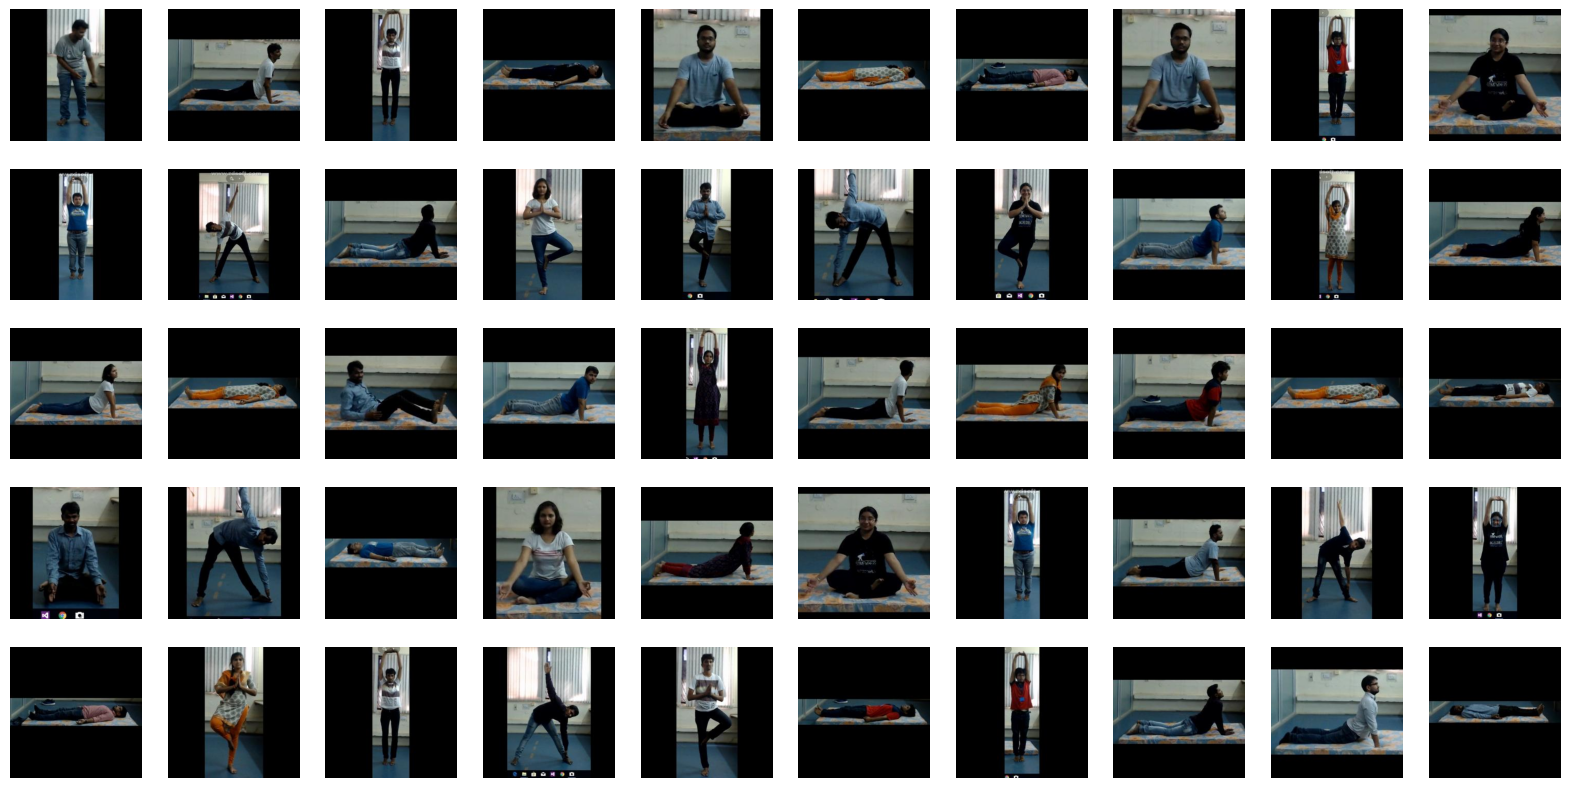

In [36]:
visualize_images('./Dataset/Padded_Images/')